# Разработка модели, прогнозирующей температуру сплава для металлургического комбината «Стальная птица»

*Финальный проект по курсу "Специалист по Data Science" от Яндекс Практикум.*

**Цель**:

Построить модель для предсказания температуры сплава на этапе обработки стали с целью уменьшения потребления электроэнергии.

**Описание задачи**:

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Описание исходных данных**:

- `data_arc_new.csv`: информация об электродах (время нагрева, активная и реактивная мощность).
- `data_bulk_new.csv`: объем сыпучих материалов.
- `data_bulk_time_new.csv`: время подачи сыпучих материалов.
- `data_gas_new.csv`: объем подаваемого газа.
- `data_temp_new.csv`: результаты измерений температуры.
- `data_wire_new.csv`: объем проволочных материалов.
- `data_wire_time_new.csv`: время подачи проволочных материалов.

Все файлы содержат столбец `key` с номером партии.

**План работы**:

- Загрузка данных: Загрузка и первичный осмотр данных.
- Исследовательский анализ и предобработка данных: Анализ и предобработка каждого датафрейма.
- Объединение данных: Объединение выбранных признаков в один датафрейм по ключу.
- Исследовательский анализ и предобработка объединенного датафрейма: Анализ объединенного датафрейма, визуализация, корреляционный анализ и предобработка.
- Подготовка данных: Подготовка данных для обучения модели, разделение на выборки, масштабирование и кодирование.
- Обучение моделей машинного обучения: Обучение как минимум двух моделей, подбор гиперпараметров.
- Выбор лучшей модели: Выбор лучшей модели и проверка её качества на тестовой выборке.
- Общий вывод и рекомендации заказчику: Описание проделанной работы, полученные результаты и рекомендации для бизнеса.

In [1]:
%%capture
!pip install phik
!pip install shap==0.44.0 matplotlib==3.3.4
!pip install -U scikit-learn

In [ ]:
import os
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import shap
from tqdm import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


sns.set_theme()

DATA_LOCAL_PATH = '/datasets/'
DATA_NETWORK_PATH = '/datasets/'
RANDOM_STATE = 170624
TEST_SIZE = 0.25

## Загрузка и первичный анализ данных

In [3]:
# загружаем датасеты
if os.path.exists(DATA_LOCAL_PATH):
    path = DATA_LOCAL_PATH
elif os.path.exists(DATA_NETWORK_PATH):
    path = DATA_NETWORK_PATH
else:
    print('Error: local or network dataset directory not found')

try:
    data = {
        "arc": pd.read_csv(path + 'data_arc_new.csv'),
        "bulk": pd.read_csv(path + 'data_bulk_new.csv'),
        "bulk_time": pd.read_csv(path + 'data_bulk_time_new.csv'),
        "gas": pd.read_csv(path + 'data_gas_new.csv'),
        "temp": pd.read_csv(path + 'data_temp_new.csv'),
        "wire": pd.read_csv(path + 'data_wire_new.csv'),
        "wire_time": pd.read_csv(path + 'data_wire_time_new.csv')
    }
except:
    print('Error: dataset not found')

In [4]:
# выведем основную информацию о датасетах
for name, df in data.items():
    print(f"{name}:")
    display(df.head(), df.describe())
    df.info()
    print(f"\nНайдено строк-дубликатов: {df.duplicated().sum()}")
    print('------------------------------------------------------------\n')

arc:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Найдено строк-дубликатов: 0
------------------------------------------------------------

bulk:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Найдено строк-дубликатов: 0
------------------------------------------------------------

bulk_time:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

Найдено строк-дубликатов: 0
------------------------------------------------------------

gas:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Найдено строк-дубликатов: 0
------------------------------------------------------------

temp:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

Найдено строк-дубликатов: 0
------------------------------------------------------------

wire:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Найдено строк-дубликатов: 0
------------------------------------------------------------

wire_time:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Найдено строк-дубликатов: 0
------------------------------------------------------------



**Вывод:** В качестве исходных данных у нас имеется 7 таблиц, в которых указаны различные параметры этапа обработки стали:
1. Таблица `arc` - данные об электродах:
    - `key` — номер партии;
    - `Начало нагрева дугой` — время начала нагрева;
    - `Конец нагрева дугой` — время окончания нагрева;
    - `Активная мощность` — значение активной мощности;
    - `Реактивная мощность` — значение реактивной мощности.
2. Таблица `bulk` - объем подачи сыпучих легирующих добавок:
    - `key` — номер партии;
    - `Bulk 1 … Bulk 15` — объём подаваемого материала.
3. Таблица `bulk_time` - время подачи сыпучих легирующих добавок:
    - `key` — номер партии;
    - `Bulk 1 … Bulk 15` — время подачи материала.
4. Таблица `gas` - объем продувочного инертного газа:
    - `key` — номер партии;
    - `Газ 1` — объём подаваемого газа.
5. Таблица `temp` - замеры температуры:
    - `key` — номер партии;
    - `Время замера` — время замера;
    - `Температура` — значение температуры.
6. Таблица `wire` - объем проволочных легирующих добавок:
    - `key` — номер партии;
    - `Wire 1 … Wire 9` — объём подаваемых проволочных материалов.
7. Таблица `wire_time` - время подачи проволочных легирующих добавок:
    - `key` — номер партии;
    - `Wire 1 … Wire 9` — время подачи проволочных материалов.

Предварительный анализ данных таблиц позволил выделить следующее:
- Имена столбцов приведены в различном стиле;
- Типы данных указаны верно, кроме столбцов, содержащих данные о времени;
- Полных дубликатов строк не обнаружено;
- Во всех таблицах, кроме `arc` и `gas` обнаружены пропуски. Однако, пропуски в объеме и времени подачи легирующих добавок наверняка означают отсутствие подачи данной добавки. А вот пропуски в столбце с температурой в таблице `temp` наверняка являются ошибкой измерительного оборудования, либо человеческим фактором;
- количество партий `key` в различных таблицах отличается;
- в таблице `arc` есть явная аномалия - отрицательная реактивная мощность;
- в таблице `temp` есть аномально низкие температуры расплава стали - минимум 1191 градус. Температура плавления стали, в зависимости от сплава, составляет 1300-1500 градусов цельсия - [пруф 1](http://zaozmi.ru/polezno/temperatura_plavleniya_metallov.html#:~:text=%D0%A1%D1%82%D0%B0%D0%BB%D1%8C,1300%2D1500), [пруф 2](http://thermalinfo.ru/svojstva-materialov/metally-i-splavy/temperatura-plavleniya-i-kipeniya-metallov-plotnost-i-teploprovodnost#:~:text=%D0%A2%D0%B5%D0%BC%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D1%83%D1%80%D0%B0%20%D0%BF%D0%BB%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F%20%D1%81%D1%82%D0%B0%D0%BB%D0%B8%20%D0%BD%D0%B0%D1%85%D0%BE%D0%B4%D0%B8%D1%82%D1%81%D1%8F%20%D0%B2%20%D0%B4%D0%B8%D0%B0%D0%BF%D0%B0%D0%B7%D0%BE%D0%BD%D0%B5%20%D0%BE%D1%82%201350%20%D0%B4%D0%BE%201535%C2%B0%D0%A1.).

## Предобработка данных

Схема предобработки данных выглядит так:

    Приводим названия столбцов к единому стилю "snake_case" => Исправляем аномальные значения мощности и температуры => Проверяем таблицы на неявные дубликаты => Меняем тип данных в столбцах с временем на datetime => Обрабатываем пропуски => Проверяем количество партий `key` в таблицах

### Обработка названий столбцов

In [ ]:
# приводим названия столбцов к единому стилю
for _name, _d in data.items():
    if _name == 'arc':
        _d.columns = [
            'key',
            'start_heating',
            'end_heating',
            'active_power',
            'reactive_power'
        ]
    if _name == 'gas':
        _d.columns = [
            'key',
            'gas_volume',
        ]
    if _name == 'temp':
        _d.columns = [
            'key',
            'measure_time',
            'temperature'
        ]
    else:
        _d.columns = [_col.lower().replace(' ', '_') for _col in _d.columns]

# проверяем
for _name, _d in data.items():
    print(f"{_name}: {_d.columns}")

arc: Index(['key', 'start_heating', 'end_heating', 'active_power',
       'reactive_power'],
      dtype='object')
bulk: Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')
bulk_time: Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')
gas: Index(['key', 'gas_volume'], dtype='object')
temp: Index(['key', 'measure_time', 'temperature'], dtype='object')
wire: Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')
wire_time: Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')


### Исправляем аномальные значения

In [6]:
# удаляем все записи для партий с отрицательной реактивной мощностью
anomaly_keys = data['arc'].query("reactive_power < 0").key
data['arc'] = data['arc'].query("key not in @anomaly_keys")

# проверяем
data['arc'].describe()

,key,active_power,reactive_power
count,14872.000000,14872.000000,14872.000000
mean,1615.085732,0.662753,0.487112
std,934.661090,0.258916,0.197623
min,1.000000,0.223120,0.153777
25%,806.000000,0.467114,0.337175
50%,1616.000000,0.599587,0.441667
75%,2429.000000,0.830314,0.608201
max,3241.000000,1.463773,1.270284


In [7]:
# удаляем все записи для партий с аномальной температурой
anomaly_keys = data['temp'].query("temperature < 1300").key
data['temp'] = data['temp'].query("key not in @anomaly_keys")

# проверяем
data['temp'].describe()

,key,temperature
count,18065.000000,14643.000000
mean,1616.423194,1590.865055
std,934.995317,19.122102
min,1.000000,1519.000000
25%,807.000000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


### Проверка на неявные дубликаты

In [8]:
def fuzzy_duplicates(name: str, subset: list = None) -> int:
    """Return the number of fuzzy duplicates in the table 'name' by columns 'subset'"""
    return data[name].duplicated(subset=subset).sum()

In [9]:
print(f"Неявные дубликаты в arc по key и start_heating: {fuzzy_duplicates('arc', subset=['key', 'start_heating'])}")
print(f"Неявные дубликаты в arc по key и end_heating: {fuzzy_duplicates('arc', subset=['key', 'end_heating'])}")
print(f"Неявные дубликаты в bulk по key: {fuzzy_duplicates('bulk', subset=['key'])}")
print(f"Неявные дубликаты в bulk_time по key: {fuzzy_duplicates('bulk_time', subset=['key'])}")
print(f"Неявные дубликаты в gas по key: {fuzzy_duplicates('gas', subset=['key'])}")
print(f"Неявные дубликаты в temp по key и measure_time: {fuzzy_duplicates('temp', subset=['key', 'measure_time'])}")
print(f"Неявные дубликаты в wire по key: {fuzzy_duplicates('wire', subset=['key'])}")
print(f"Неявные дубликаты в wire_time по key: {fuzzy_duplicates('wire_time', subset=['key'])}")

Неявные дубликаты в arc по key и start_heating: 0
Неявные дубликаты в arc по key и end_heating: 0
Неявные дубликаты в bulk по key: 0
Неявные дубликаты в bulk_time по key: 0
Неявные дубликаты в gas по key: 0
Неявные дубликаты в temp по key и measure_time: 0
Неявные дубликаты в wire по key: 0
Неявные дубликаты в wire_time по key: 0


### Обработка типов данных

In [10]:
# напишем функцию для замены типа данных с временем на datetime
def set_datetime(name: str, columns) -> None:
    """Converts specified column(s) to datetime format"""
    if isinstance(columns, str):
        columns = [columns]
    for col in columns:
        data[name][col] = pd.to_datetime(data[name][col], format='%Y-%m-%d %H:%M:%S')


# исправляем тип данных
set_datetime('arc', 'start_heating')
set_datetime('arc', 'end_heating')
set_datetime('bulk_time', data['bulk_time'].columns[1:])
set_datetime('temp', 'measure_time')
set_datetime('wire_time', data['wire_time'].columns[1:])

# проверяем
for _name in ('arc', 'bulk_time', 'temp', 'wire_time'):
    print(f"{_name}:\n")
    data[_name].info()
    print('------------------------------------------------------------\n')

arc:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14872 non-null  int64         
 1   start_heating   14872 non-null  datetime64[ns]
 2   end_heating     14872 non-null  datetime64[ns]
 3   active_power    14872 non-null  float64       
 4   reactive_power  14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB
------------------------------------------------------------

bulk_time:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]


### Обработка пропусков

Про пропуски в объеме и времени подачи легирующих добавок уже было сказано выше - наверняка они означают отсутствие подачи данной добавки - поэтому такие пропуски можно заполнить нулями. Но перед этим проверим, что каждому объему легирующей добавки соответствует время добавления данного компонента.

In [11]:
# проверяем, сходятся ли таблицы с объемами и временами добавления легирующих компонентов 
print(f"Таблицы bulk и bulk_time сходятся: {(data['bulk'].isna() == data['bulk_time'].isna()).all(axis=None)}")
print(f"Таблицы wire и wire_time сходятся: {(data['wire'].isna() == data['wire_time'].isna()).all(axis=None)}")

Таблицы bulk и bulk_time сходятся: True
Таблицы wire и wire_time сходятся: True


На данном этапе пропуски в `bulk_time` и `wire_time` заполнять не будем - сделаем это после генерации новых фичей.

In [12]:
# заполняем пропуски нулями
for _name in ('bulk', 'wire'):
    data[_name] = data[_name].fillna(0)
    
    # проверяем
    print(f"{_name}:\n")
    display(data[_name].head())
    data[_name].info()
    print('------------------------------------------------------------\n')

bulk:



,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
------------------------------------------------------------

wire:



,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
------------------------------------------------------------



Теперь посмотрим на количество пропусков в данных о температуре расплава.

In [13]:
print(f"Количество пропусков в данных о температуре расплава: {data['temp'].temperature.isna().sum()}")
print(f"Количество партий, где есть пропуски в данных о темп. расплава: {data['temp'][data['temp'].temperature.isna()].key.unique().shape[0]}")

Количество пропусков в данных о температуре расплава: 3422
Количество партий, где есть пропуски в данных о темп. расплава: 738


Пропуски в температуре игнорировать нельзя по следующей причине:

Забегая вперед, следует отметить, что показатели температуры нам нужны как для использования их в качестве целевого признака, так и для генерации нового входного признака - температуры расплава в начале обработки. Поэтому важно, чтобы в конечном счете в данных у каждой операции было и то, и другое значение.

Поэтому строки, где есть пропуски в первой или последней записи соответствующей партии, нужно удалить.

In [14]:
# удаляем строки с партиями, где есть пропуски
data['temp'] = data['temp'][~data['temp'].key.isin(data['temp'][data['temp'].temperature.isna()].key)]

In [15]:
# проверим все таблицы на пропуски
for _name, _d in data.items():
    print(f"Пропусков в таблице {_name}: {_d.isna().sum().sum()}")

Пропусков в таблице arc: 0
Пропусков в таблице bulk: 0
Пропусков в таблице bulk_time: 35776
Пропусков в таблице gas: 0
Пропусков в таблице temp: 0
Пропусков в таблице wire: 0
Пропусков в таблице wire_time: 23385


### Проверка количества партий в таблицах

Посмотрим на количество партий в разных таблицах

In [16]:
for _name, _d in data.items():
    print(f"Кол-во партий в таблице {_name}: {_d.key.unique().shape[0]}")

Кол-во партий в таблице arc: 3213
Кол-во партий в таблице bulk: 3129
Кол-во партий в таблице bulk_time: 3129
Кол-во партий в таблице gas: 3239
Кол-во партий в таблице temp: 2473
Кол-во партий в таблице wire: 3081
Кол-во партий в таблице wire_time: 3081


Как можно заметить, количество партий меняется от таблице к таблице. Однако, нельзя с уверенностью сказать, что это некомплект данных. Например, отсутствие определенных партий в таблицах с данными о сыпучих или проволочных добавках может означать отсутствие данного типа легирующих добавок в рецептуре конкретной партии, однако это необходимо уточнять у заказчика.

Так как такой возможности нет, то не будем включать партии с отсутствующими данными в объединенный датасет - все объединения нужно будет делать по ключу с `how='inner'`.

**Вывод:** в данном разделе была проведена предобработка данных, а именно:
- Названия столбцов приведены к стилю "snake_case";
- Исправлены аномалии в данных о реактивной мощности и температуре;
- Данные проверены на наличие полных и неявных дубликатов;
- Столбцы с временем приведены к верному типу данных `datetime`;
- Обработаны пропуски в данных.

## Объединение таблиц в единый датасет

Прежде чем объединять таблицы, необходимо разобрать техпроцесс, чтобы понимать какие фичи нам необходимо включить в датасет.

Схема техпроцесса легирования стали:

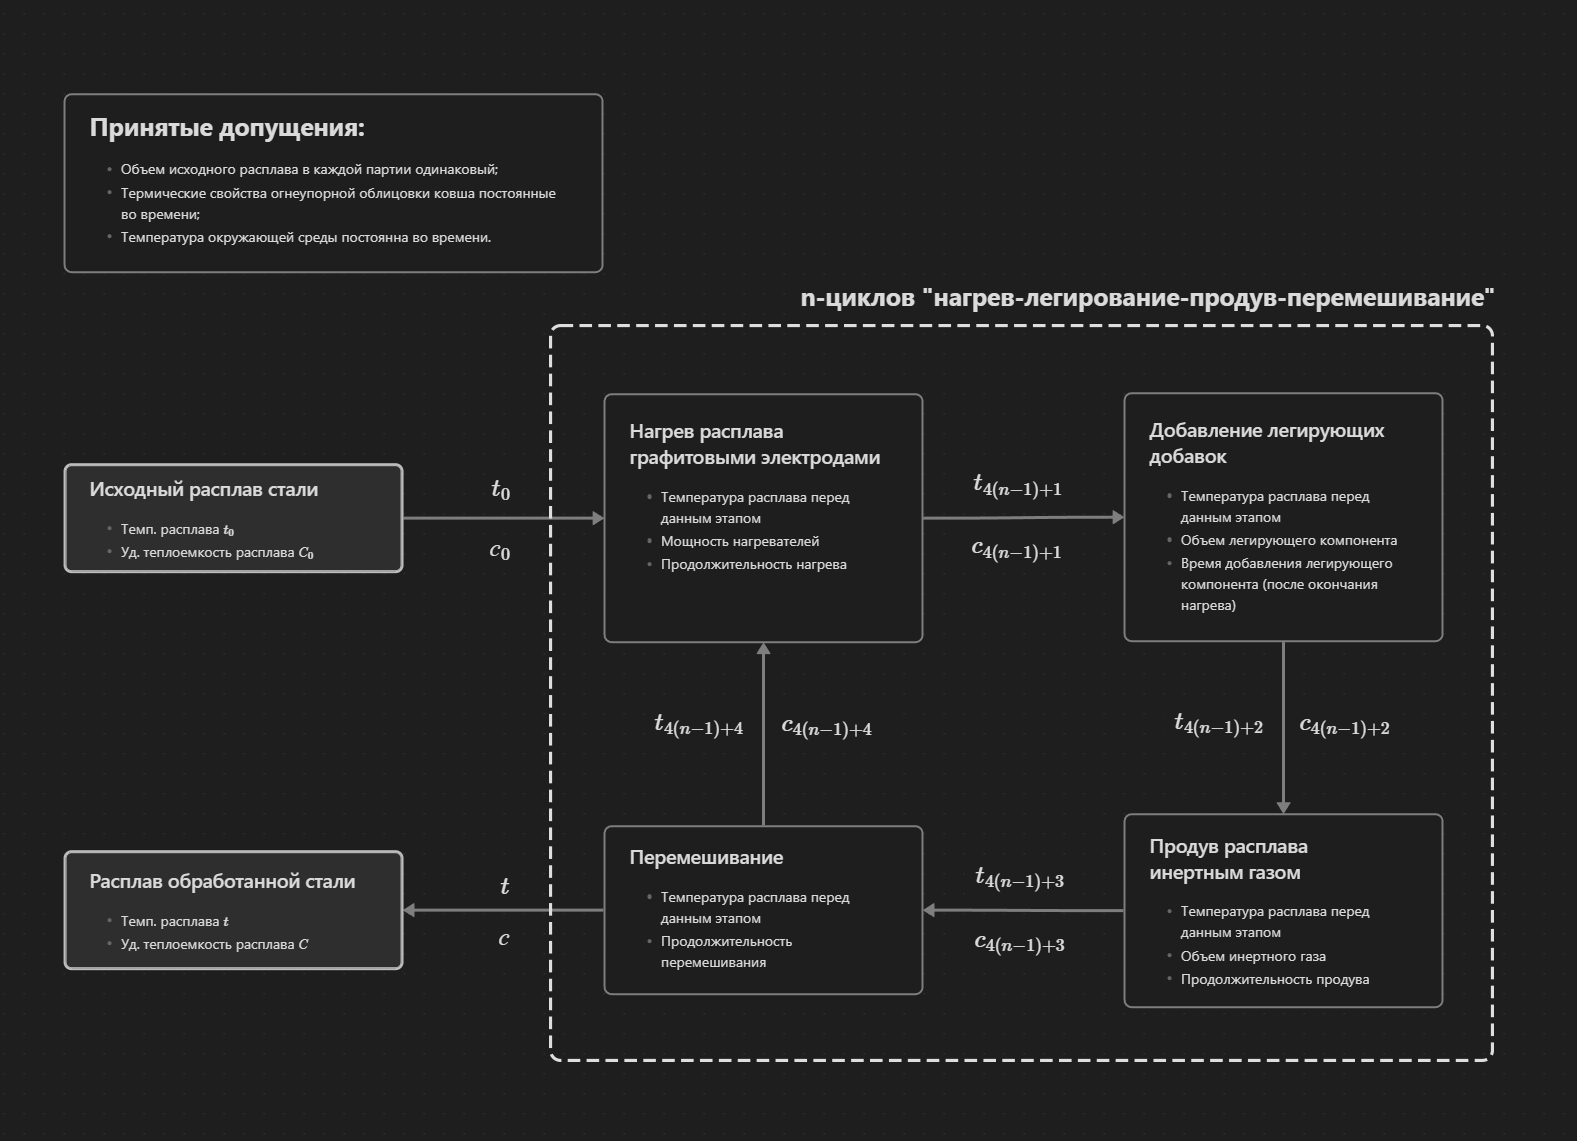

Разберем, какие факторы влияют на нашу целевую переменную - температуру расплава определенной партии в конце обработки (на схеме это $t$).

Изменение температуры (если немного упрощенно подходить к данному вопросу) на каждой стадии зависит от количества подведенного/отведенного от расплава тепла и теплоемкости расплава.

Подводиться тепло может:
- при нагреве графитовыми электродами - на это влияет мощность тока, подаваемого на нагреватели;
- при экзотермических химических реакциях, происходящих в расплаве (т.е. реакциях, при которых выделяется тепло).

Отводиться тепло может:
- при принудительном охлаждении расплава - например, при продувке инертным газом;  
- при потерях в окружающую среду и в конструкцию реактора;
- при эндотермических химических реакциях, происходящих в расплаве (т.е. реакциях, при которых расходуется тепло).

Удельная теплоемкость расплава - это количество тепла, необходимое для нагрева 1 кг расплава на 1 градус.

Теплоемкость расплава меняется:
- при изменении состава расплава;
- при изменении его температуры (для сталей нужно уточнять, но обычно с увеличением температуры, увеличивается и теплоемкость материала, т.е. чем он горячее, тем его сложнее нагреть).

Таким образом, учитывая имеющиеся у нас наборы данных, можно выделить следующий набор признаков, которые будут характеризовать температуру расплава в конце обработки:
- количество итераций в партии;
- температура расплава в начале обработки;
- средняя продолжительность нагрева;
- суммарная продолжительность нагрева;
- средняя активная мощность нагревателей;
- средняя реактивная мощность нагревателей;
- средняя полная мощность нагревателей*;
- средняя работа, затраченная на нагрев**;
- суммарная работа, затраченная на нагрев**;
- среднее и суммарное время, прошедшее после окончания нагрева, через которое добавили легирующий компонент (т.к. влияет на потери тепла);
- среднее и суммарное время, прошедшее от добавления легирующего компонента до измерения температуры (влияет и на изменение тепла и на теплоемкость***);
- состав расплава: объем каждого добавленного в расплав легирующего компонента (т.к. влияет на теплоемкость);
- количество затраченного продувочного газа.

\* с помощью активной и реактивной мощностей можно рассчитать полную мощность по формуле $S = \sqrt{P^2 + Q^2}$, где $P$ - активная мощность, а $Q$ - реактивная мощность.

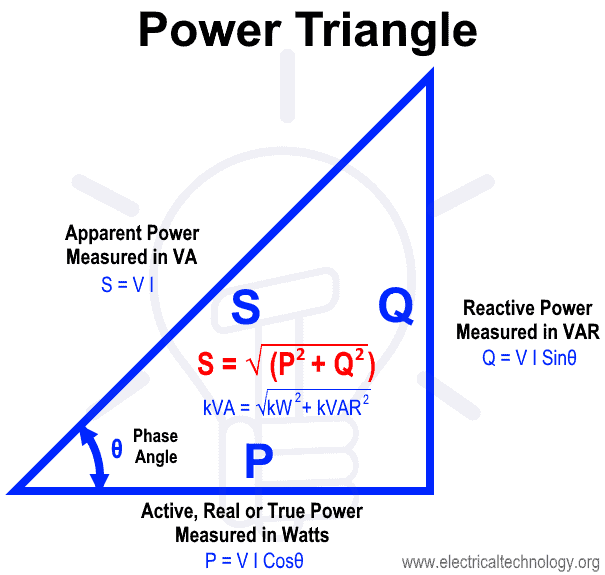

\** работа рассчитывается по формуле $A_n = S_n \cdot t_n$, где $A_n$ - работа нагревателя на итерации $n$, $S_n$ - полная мощность на итерации $n$, $t_n$ - продолжительность нагрева на итерации $n$.

\*** теплоемкость расплава, в который только что добавили легирующий компонент и который прошел стадии продува и перемешивания, будет отличаться, т.к. во втором случае состав и характеристики расплава стабилизируются по его объему.

Для того, чтобы определить порядок действий по генерации новых фичей и объединению датасета, взглянем на все данные по рандомной партии

In [17]:
# отдельно определим число для random_state, чтобы при каждом выполнении данной ячейки выбиралась новая партия
r = randint(1, 42)

for _name, _d in data.items():
    print(f"Таблица {_name}:")
    display(_d.query("key == @data['temp'].key.sample(random_state=@r).iloc[0]"))

Таблица arc:


,key,start_heating,end_heating,active_power,reactive_power
7204,1565,2019-07-01 07:41:41,2019-07-01 07:43:33,0.446219,0.345717
7205,1565,2019-07-01 07:45:26,2019-07-01 07:53:14,0.768365,0.579325
7206,1565,2019-07-01 07:56:06,2019-07-01 07:58:43,0.396090,0.293903


Таблица bulk:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
1508,1565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,416.0,0.0,199.0,0.0


Таблица bulk_time:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
1508,1565,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-07-01 07:58:55,NaT,2019-07-01 07:53:33,NaT


Таблица gas:


,key,gas_volume
1562,1565,5.099318


Таблица temp:


,key,measure_time,temperature
8754,1565,2019-07-01 07:41:31,1637.0
8755,1565,2019-07-01 07:45:16,1648.0
8756,1565,2019-07-01 07:55:56,1652.0
8757,1565,2019-07-01 08:01:05,1658.0


Таблица wire:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9


Таблица wire_time:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9


Судя по имеющимся данным, порядок действий по подготовке объединенного датасета следующий:
- добавляем в таблицы `arc` и `temp` столбец `iteration`, в котором будет указана соответствующая итерация. При этом первая строка в таблице `temp` будет 0-ой итерацией, т.к. это начальное измерение температуры. Данный столбец нам нужен для объединения этих таблиц;
- объединяем таблицы `arc` и `temp` по ключу и итерации;
- добавляем данные о времени добавления легирующих компонентов из `bulk_time` и `wire_time`. При этом данные нужно немного трансформировать, чтобы учитывать состав расплава на каждой итерации: если время добавления соответствующего компонента больше чем время конца нагрева, но меньше чем время измерения температуры в данной итерации, то время добавления компонента оставляем, а если нет - заполняем пропуском;
- добавляем новые фичи по итерациям: продолжительность нагрева, время от конца нагрева до добавления компонента, время от добавления компонента до измерения температуры, температуру в начале итерации, полная мощность и затраченная работа. Время от начального измерения температуры и до начала нагрева добавлять не будем, так как оно одинаково для всех итераций (10 секунд) - проверку вставил в ячейке ниже;
- агрегируем данные по ключу с выделением новых фичей;
- добавляем объемы легирующих компонентов из `bulk` и `wire` и объем газа по ключу;
- удаляем лишние столбцы, которые не нужны для обучения моделей: `key`, `start_heating`, `end_heating`, `measure_time`;
- проверяем датасет на полные дубликаты и если они есть - удаляем.

In [18]:
## Проверка времени от начального измерения до начала нагрева

# собираем вспомогательные таблицы
_t = data['temp'].copy()
_arc = data['arc'].copy()

# добавляем столбец с временем начального измерения 
_t['m'] = _t.groupby('key')['measure_time'].shift(1)

# добавляем столбец с номером итерации
_t['i'] = _t.groupby('key').cumcount() # номер итерации будет начинаться с 0, т.к. есть начальное измерение
_arc['i'] = _arc.groupby('key').cumcount() + 1 # номер итерации будет начинаться с 1

# соединяем по ключу и итерации
_t = _t.merge(_arc, on=['key', 'i'], how='inner')

# проверяем уникальные значения времени от начального измерения температуры до начала нагрева
(_t['start_heating'] - _t['m']).dt.total_seconds().unique()

array([10.])

Как видно выше, данное время для всех партий и итераций одинаково, поэтому для модели данный признак будет бесполезным. 

In [19]:
# сортируем таблицы `arc` и `temp` по ключу и времени, чтобы корректно указать номер итерации
data['arc'] = data['arc'].sort_values(by=['key', 'start_heating'])
data['temp'] = data['temp'].sort_values(by=['key', 'measure_time'])

# добавляем столбец с номером итерации в таблицы `arc` и `temp`
data['arc']['iteration'] = data['arc'].groupby('key').cumcount() + 1 
data['temp']['iteration'] = data['temp'].groupby('key').cumcount()

# добавим столбец с начальным измерением температуры для каждой итерации
data['temp']['temperature_0'] = data['temp'].groupby('key')['temperature'].shift(1)

# объединяем таблицы `arc` и `temp` по ключу и итерации
df = data['temp'].merge(data['arc'], on=['key', 'iteration'], how='inner')

# добавляем данные по легирующим добавкам
df = df\
    .merge(data['bulk_time'], on='key', how='inner')\
    .merge(data['wire_time'], on='key', how='inner')

# проверяем
df.head(10)

,key,measure_time,temperature,iteration,temperature_0,start_heating,end_heating,active_power,reactive_power,bulk_1,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:07:18,1604.0,1,1571.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,NaT,...,2019-05-03 11:10:43,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,1,2019-05-03 11:11:34,1618.0,2,1604.0,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,NaT,...,2019-05-03 11:10:43,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,1,2019-05-03 11:18:04,1601.0,3,1618.0,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,NaT,...,2019-05-03 11:10:43,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,1,2019-05-03 11:25:59,1606.0,4,1601.0,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,NaT,...,2019-05-03 11:10:43,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,1,2019-05-03 11:30:38,1613.0,5,1606.0,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,NaT,...,2019-05-03 11:10:43,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2,2019-05-03 11:38:40,1577.0,1,1581.0,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,NaT,...,2019-05-03 11:44:39,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,2,2019-05-03 11:46:09,1589.0,2,1577.0,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,NaT,...,2019-05-03 11:44:39,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,2,2019-05-03 11:49:38,1604.0,3,1589.0,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,NaT,...,2019-05-03 11:44:39,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,2,2019-05-03 11:55:09,1602.0,4,1604.0,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,NaT,...,2019-05-03 11:44:39,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,3,2019-05-03 12:13:42,1597.0,1,1596.0,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,NaT,...,2019-05-03 12:16:16,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [20]:
# сохраняем столбцы с временем добавления компонентов
time_columns = [col for col in df.columns if 'bulk' in col or 'wire' in col]

# с п-ю np.where трансформируем столбцы
for _col in time_columns:
    df[_col] = np.where(
        (df[_col] > df['end_heating']) & (df[_col] < df['measure_time']),
        df[_col],
        None
    )

# проверяем
df.head(10)

,key,measure_time,temperature,iteration,temperature_0,start_heating,end_heating,active_power,reactive_power,bulk_1,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:07:18,1604.0,1,1571.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,None,...,None,1556881579000000000,None,None,None,None,None,None,None,None
1,1,2019-05-03 11:11:34,1618.0,2,1604.0,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,None,...,1556881843000000000,None,None,None,None,None,None,None,None,None
2,1,2019-05-03 11:18:04,1601.0,3,1618.0,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,None,...,None,None,None,None,None,None,None,None,None,None
3,1,2019-05-03 11:25:59,1606.0,4,1601.0,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,None,...,None,None,None,None,None,None,None,None,None,None
4,1,2019-05-03 11:30:38,1613.0,5,1606.0,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,None,...,None,None,None,None,None,None,None,None,None,None
5,2,2019-05-03 11:38:40,1577.0,1,1581.0,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,None,...,None,1556883410000000000,None,None,None,None,None,None,None,None
6,2,2019-05-03 11:46:09,1589.0,2,1577.0,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,None,...,1556883879000000000,None,None,None,None,None,None,None,None,None
7,2,2019-05-03 11:49:38,1604.0,3,1589.0,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,None,...,None,None,None,None,None,None,None,None,None,None
8,2,2019-05-03 11:55:09,1602.0,4,1604.0,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,None,...,None,None,None,None,None,None,None,None,None,None
9,3,2019-05-03 12:13:42,1597.0,1,1596.0,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,None,...,None,1556885506000000000,None,None,None,None,None,None,None,None


In [21]:
# добавим вспомогательный столбец с временем добавления легирующих компонентов
df['a_time'] = pd.to_datetime(df[time_columns].mean(axis=1)).fillna(df['end_heating'])

# добавляем столбец с продолжительностью нагрева
df['heating_time'] = (df['end_heating'] - df['start_heating']).astype('int64') // 10**9

# добавляем столбец с временем, прошедшим от окончания нагрева до добавления легирующего компонента
df['alloying_time'] = (df['a_time'].astype('int64') - df['end_heating'].astype('int64')) // 10**9

# добавляем столбец с временем, прошедшим от добавления легирующего компонента до измерения температуры в конце итерации
df['time_till_temp_measurement'] = (df['measure_time'].astype('int64') - df['a_time'].astype('int64')) // 10**9

# добавляем столбец с полной мощностью нагревателей
df['apparent_power'] = ((df['active_power'])**2 + (df['reactive_power'])**2)**0.5

# добавляем столбец с затраченной работой
df['work'] = df['apparent_power'] * df['heating_time']

# Удаляем ненужные столбцы с временами
df = df.drop(time_columns + ['measure_time', 'start_heating', 'end_heating', 'a_time'], axis=1)

# проверяем
df.head(10)

,key,temperature,iteration,temperature_0,active_power,reactive_power,heating_time,alloying_time,time_till_temp_measurement,apparent_power,work
0,1,1604.0,1,1571.0,0.305130,0.211253,228,17,59,0.371123,84.616003
1,1,1618.0,2,1604.0,0.765658,0.477438,185,10,51,0.902319,166.928978
2,1,1601.0,3,1618.0,0.580313,0.430460,172,14,194,0.722536,124.276277
3,1,1606.0,4,1601.0,0.518496,0.379979,365,12,88,0.642824,234.630603
4,1,1613.0,5,1606.0,0.867133,0.643691,148,11,110,1.079934,159.830252
5,2,1577.0,1,1581.0,0.381124,0.220351,137,19,110,0.440239,60.312695
6,2,1589.0,2,1577.0,0.261665,0.205527,338,11,90,0.332731,112.463079
7,2,1604.0,3,1589.0,0.710297,0.484962,126,12,61,0.860064,108.368056
8,2,1602.0,4,1604.0,0.786322,0.542517,210,12,99,0.955315,200.616176
9,3,1597.0,1,1596.0,1.101678,0.820856,280,12,116,1.373863,384.681584


In [22]:
# собираем объединенный датасет
df = df.groupby('key').agg(
    iteration_count=('iteration', 'count'),
    temperature_0=('temperature_0', 'first'),
    avg_heating_time=('heating_time', 'mean'),
    total_heating_time=('heating_time', 'sum'),
    avg_active_power=('active_power', 'mean'),
    avg_reactive_power=('reactive_power', 'mean'),
    avg_apparent_power=('apparent_power', 'mean'),
    avg_work=('work', 'mean'),
    total_work=('work', 'sum'),
    avg_alloying_time=('alloying_time', 'mean'),
    total_alloying_time=('alloying_time', 'sum'),
    avg_time_till_temp_measurement=('time_till_temp_measurement', 'mean'),
    total_time_till_temp_measurement=('time_till_temp_measurement', 'sum'),
    temperature=('temperature', 'last')
).reset_index()

df.head()

,key,iteration_count,temperature_0,avg_heating_time,total_heating_time,avg_active_power,avg_reactive_power,avg_apparent_power,avg_work,total_work,avg_alloying_time,total_alloying_time,avg_time_till_temp_measurement,total_time_till_temp_measurement,temperature
0,1,5,1571.0,219.60,1098,0.607346,0.428564,0.743747,154.056423,770.282114,12.80,64,100.40,502,1613.0
1,2,4,1581.0,202.75,811,0.534852,0.363339,0.647087,120.440001,481.760005,13.50,54,90.00,360,1602.0
2,3,5,1596.0,131.00,655,0.812728,0.587491,1.003845,144.567534,722.837668,16.20,81,193.40,967,1599.0
3,4,4,1601.0,185.25,741,0.676622,0.514248,0.850010,170.863899,683.455597,14.50,58,95.25,381,1625.0
4,5,4,1576.0,217.25,869,0.563238,0.421998,0.704245,128.042484,512.169934,14.25,57,142.25,569,1602.0


In [23]:
# добавляем объемы легирующих компонентов и газа
df = df\
    .merge(data['bulk'], on='key', how='inner')\
    .merge(data['wire'], on='key', how='inner')\
    .merge(data['gas'], on='key', how='inner')

# удаляем столбец key, т.к. для обучения модели он не нужен 
df = df.drop('key', axis=1).reset_index(drop=True)

# для удобства переместим целевую переменную temperature в конец
columns = df.columns.tolist()
columns.append(columns.pop(columns.index('temperature')))
df = df[columns]

# проверяем
display(df.head())
df.info()

,iteration_count,temperature_0,avg_heating_time,total_heating_time,avg_active_power,avg_reactive_power,avg_apparent_power,avg_work,total_work,avg_alloying_time,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_volume,temperature
0,5,1571.0,219.60,1098,0.607346,0.428564,0.743747,154.056423,770.282114,12.80,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1613.0
1,4,1581.0,202.75,811,0.534852,0.363339,0.647087,120.440001,481.760005,13.50,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1602.0
2,5,1596.0,131.00,655,0.812728,0.587491,1.003845,144.567534,722.837668,16.20,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1599.0
3,4,1601.0,185.25,741,0.676622,0.514248,0.850010,170.863899,683.455597,14.50,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1625.0
4,4,1576.0,217.25,869,0.563238,0.421998,0.704245,128.042484,512.169934,14.25,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1602.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   iteration_count                   2324 non-null   int64  
 1   temperature_0                     2324 non-null   float64
 2   avg_heating_time                  2324 non-null   float64
 3   total_heating_time                2324 non-null   int64  
 4   avg_active_power                  2324 non-null   float64
 5   avg_reactive_power                2324 non-null   float64
 6   avg_apparent_power                2324 non-null   float64
 7   avg_work                          2324 non-null   float64
 8   total_work                        2324 non-null   float64
 9   avg_alloying_time                 2324 non-null   float64
 10  total_alloying_time               2324 non-null   int64  
 11  avg_time_till_temp_measurement    2324 non-null   float64
 12  total_

In [24]:
# проверяем на полные дубликаты
print(f"Полных дубликатов: {df.duplicated().sum()}")

Полных дубликатов: 0


**Вывод:** в данном разделе были проведены процессы генерации новых фичей и объединения таблиц в единый датасет для моделирования температуры расплава стали в конце обработки. На основе анализа техпроцесса легирования стали и имеющихся данных, были выделены ключевые признаки, влияющие на целевую переменную.

Итоговый набор признаков получился следующим:
- количество итераций в партии - `iteration_count`;
- температура расплава в начале обработки - `temperature_0`;
- средняя продолжительность нагрева - `avg_heating_time`;
- суммарная продолжительность нагрева - `total_heating_time`;
- средняя активная мощность нагревателей - `avg_active_power`;
- средняя реактивная мощность нагревателей - `avg_reactive_power`;
- средняя полная мощность нагревателей* - `avg_apparent_power`;
- средняя работа, затраченная на нагрев** - `avg_work`;
- суммарная работа, затраченная на нагрев** - `total_work`;
- среднее и суммарное время, прошедшее после окончания нагрева, через которое добавили легирующий компонент (т.к. влияет на потери тепла) - `avg_alloying_time` и `total_alloying_time`;
- среднее и суммарное время, прошедшее от добавления легирующего компонента до измерения температуры (влияет и на изменение тепла и на теплоемкость***) - `avg_time_till_temp_measurement` и `total_time_till_temp_measurement`;
- состав расплава: объем каждого добавленного в расплав легирующего компонента (т.к. влияет на теплоемкость) - `bulk_1...15` и `wire_1...9`;
- количество затраченного продувочного газа - `gas_volume`.

## EDA

### Анализ количественных переменных

In [ ]:
# напишем ф-ю для стат. анализа количественных переменных, в которой, помимо прочих, будет именованный
# аргумент bins для настройки кол-ва корзин в каждой гистограмме и disc_features для указания дискретных признаков
def num_col_stats(df, figsize=(18, 4), disc_features=[], bins=10, show_describe=True):
    # записываем столбцы с количественными переменными 
    num_columns = df.select_dtypes(exclude=['object']).columns.tolist()

    # распределяем столюцы из разчета 6 графиков в ряд
    columns_on_rows = [num_columns[i:i+6] for i in range(0, len(num_columns), 6)]

    # строим графики
    for i, cols in enumerate(columns_on_rows):

        fig, axs = plt.subplots(2, 6, figsize=figsize, gridspec_kw={'height_ratios': (1, 5)})

        if i == 0:
            plt.suptitle('Гистограммы распределения количественных признаков', y=1.02)

        for j, col in enumerate(cols):
            # строим boxplot
            box = sns.boxplot(data=df, x=col, ax=axs[0][j])
            box.set_xlabel('')
            box.set_xticks([])
            # для дискретных признаков строим countplot, а для непрерыных histplot
            if col in disc_features:
                sns.countplot(data=df, x=col, ax=axs[1][j])
            else:
                sns.histplot(data=df, x=col, bins=bins, ax=axs[1][j])

        plt.tight_layout()

    # очищаем пустые графики в конце последней строки, если они есть
    for j in range(6 - (6*(i+1) - len(num_columns)), 6):
        axs[0][j].set_xticks([])       
        axs[0][j].set_yticks([])
        axs[0][j].set_facecolor('white')
        axs[1][j].set_xticks([])
        axs[1][j].set_yticks([])
        axs[1][j].set_facecolor('white')

    plt.show()

    # соберем таблицу с описательной статистикой
    if show_describe:
        display(df.describe())

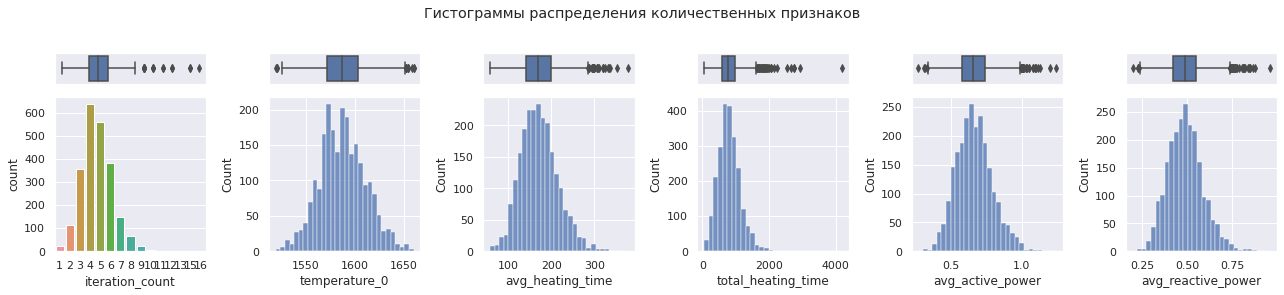

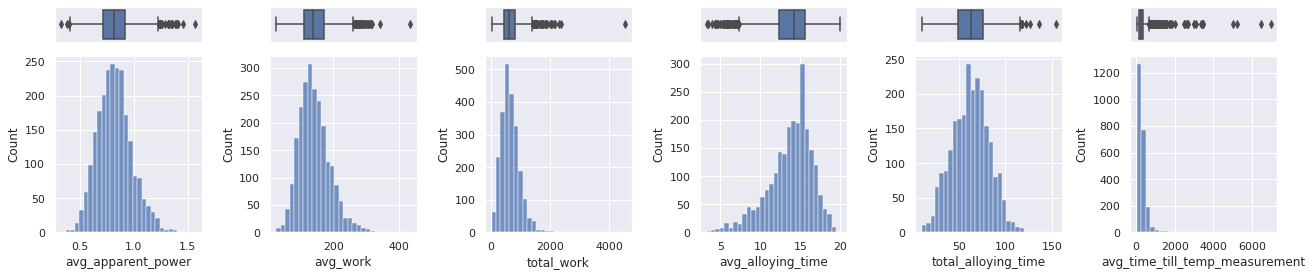

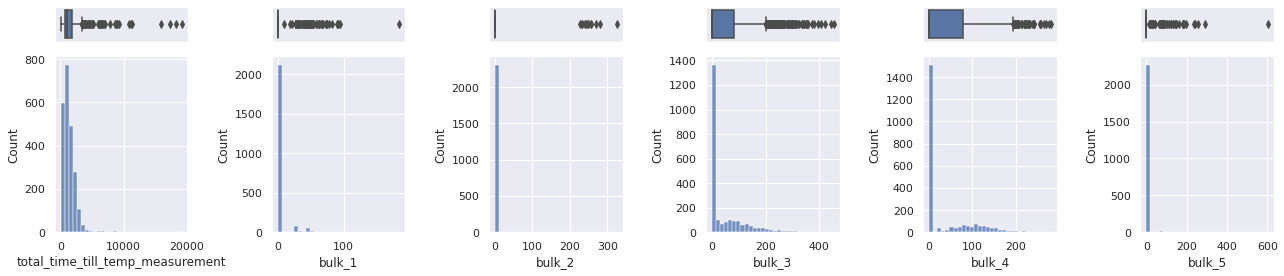

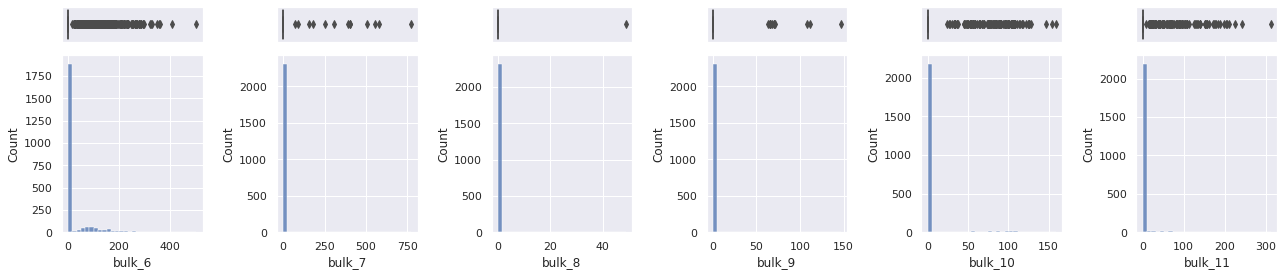

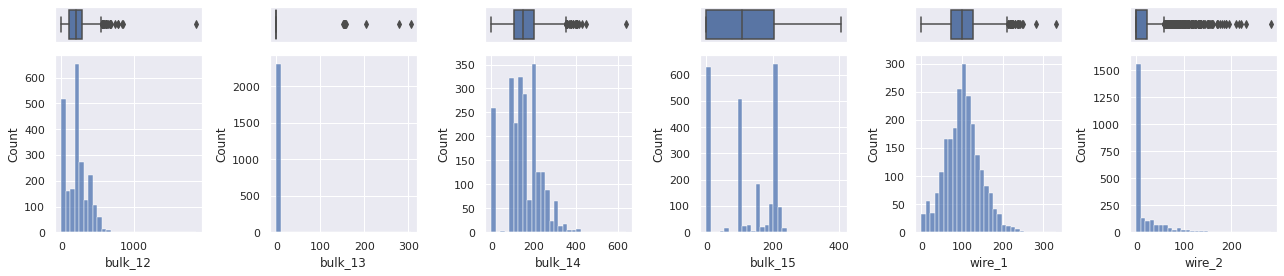

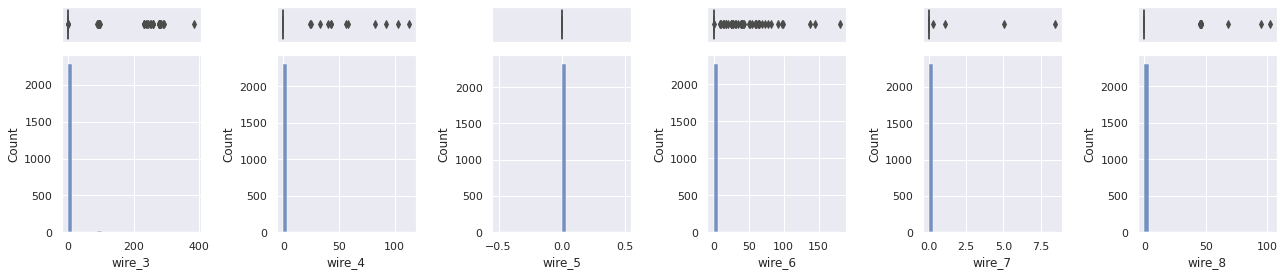

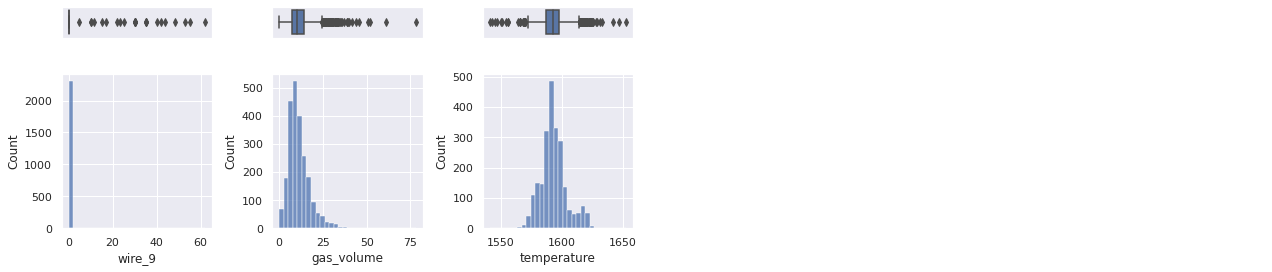

,iteration_count,temperature_0,avg_heating_time,total_heating_time,avg_active_power,avg_reactive_power,avg_apparent_power,avg_work,total_work,avg_alloying_time,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_volume,temperature
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,...,2324.000000,2324.000000,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,4.696644,1587.368761,172.118124,808.196644,0.664209,0.488921,0.825641,142.445326,670.232396,13.738389,...,17.613213,3.241876,0.307209,0.0,0.980926,0.006374,0.311981,0.317795,11.378854,1593.372633
std,1.606210,23.627590,43.740469,340.813828,0.128419,0.098024,0.160411,47.550504,319.526707,2.742651,...,33.648176,27.972523,4.762842,0.0,8.702531,0.205926,4.407419,3.460248,6.397008,11.207457
min,1.000000,1519.000000,57.000000,57.000000,0.267676,0.196228,0.331897,25.227273,33.430208,3.285714,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008399,1541.000000
25%,4.000000,1571.000000,141.000000,581.000000,0.576159,0.420039,0.714277,108.964289,457.924990,12.276786,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.282534,1587.000000
50%,5.000000,1587.000000,169.500000,778.000000,0.655834,0.484669,0.818302,136.265215,631.228863,14.250000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,10.100687,1593.000000
75%,6.000000,1603.000000,198.750000,993.000000,0.741883,0.546693,0.921313,170.600050,841.824214,15.600000,...,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,14.218487,1598.000000
max,16.000000,1660.000000,378.000000,4189.000000,1.243889,0.960763,1.572238,436.387492,4546.405812,20.000000,...,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,77.995040,1653.000000


In [26]:
num_col_stats(df, disc_features=['iteration_count'], bins=30)

Как можно заметить по представленным графикам, в данных имеется достаточно много выбросов в различных признаках. Однако, чтобы не ограничивать предсказательную способность модели, пока что оставим их. Также можно отметить, что в датасете очень мало данных для многих легирующих добавок. Возможно, придется суммировать какие-то добавки друг с другом.

### Корреляционный анализ

In [27]:
def phik_matrix_heatmap(df, figsize=(20, 20)):
    # Корреляционноя матрица входных признаков и таргета
    df_phik = df.phik_matrix(interval_cols=df.select_dtypes(exclude=['object']).columns.tolist())

    plt.figure(figsize=figsize)
    sns.heatmap(df_phik, annot=True)
    plt.suptitle('Корреляционная матрица')
    plt.tight_layout();

Not enough unique value for variable wire_5 for analysis 1. Dropping this column


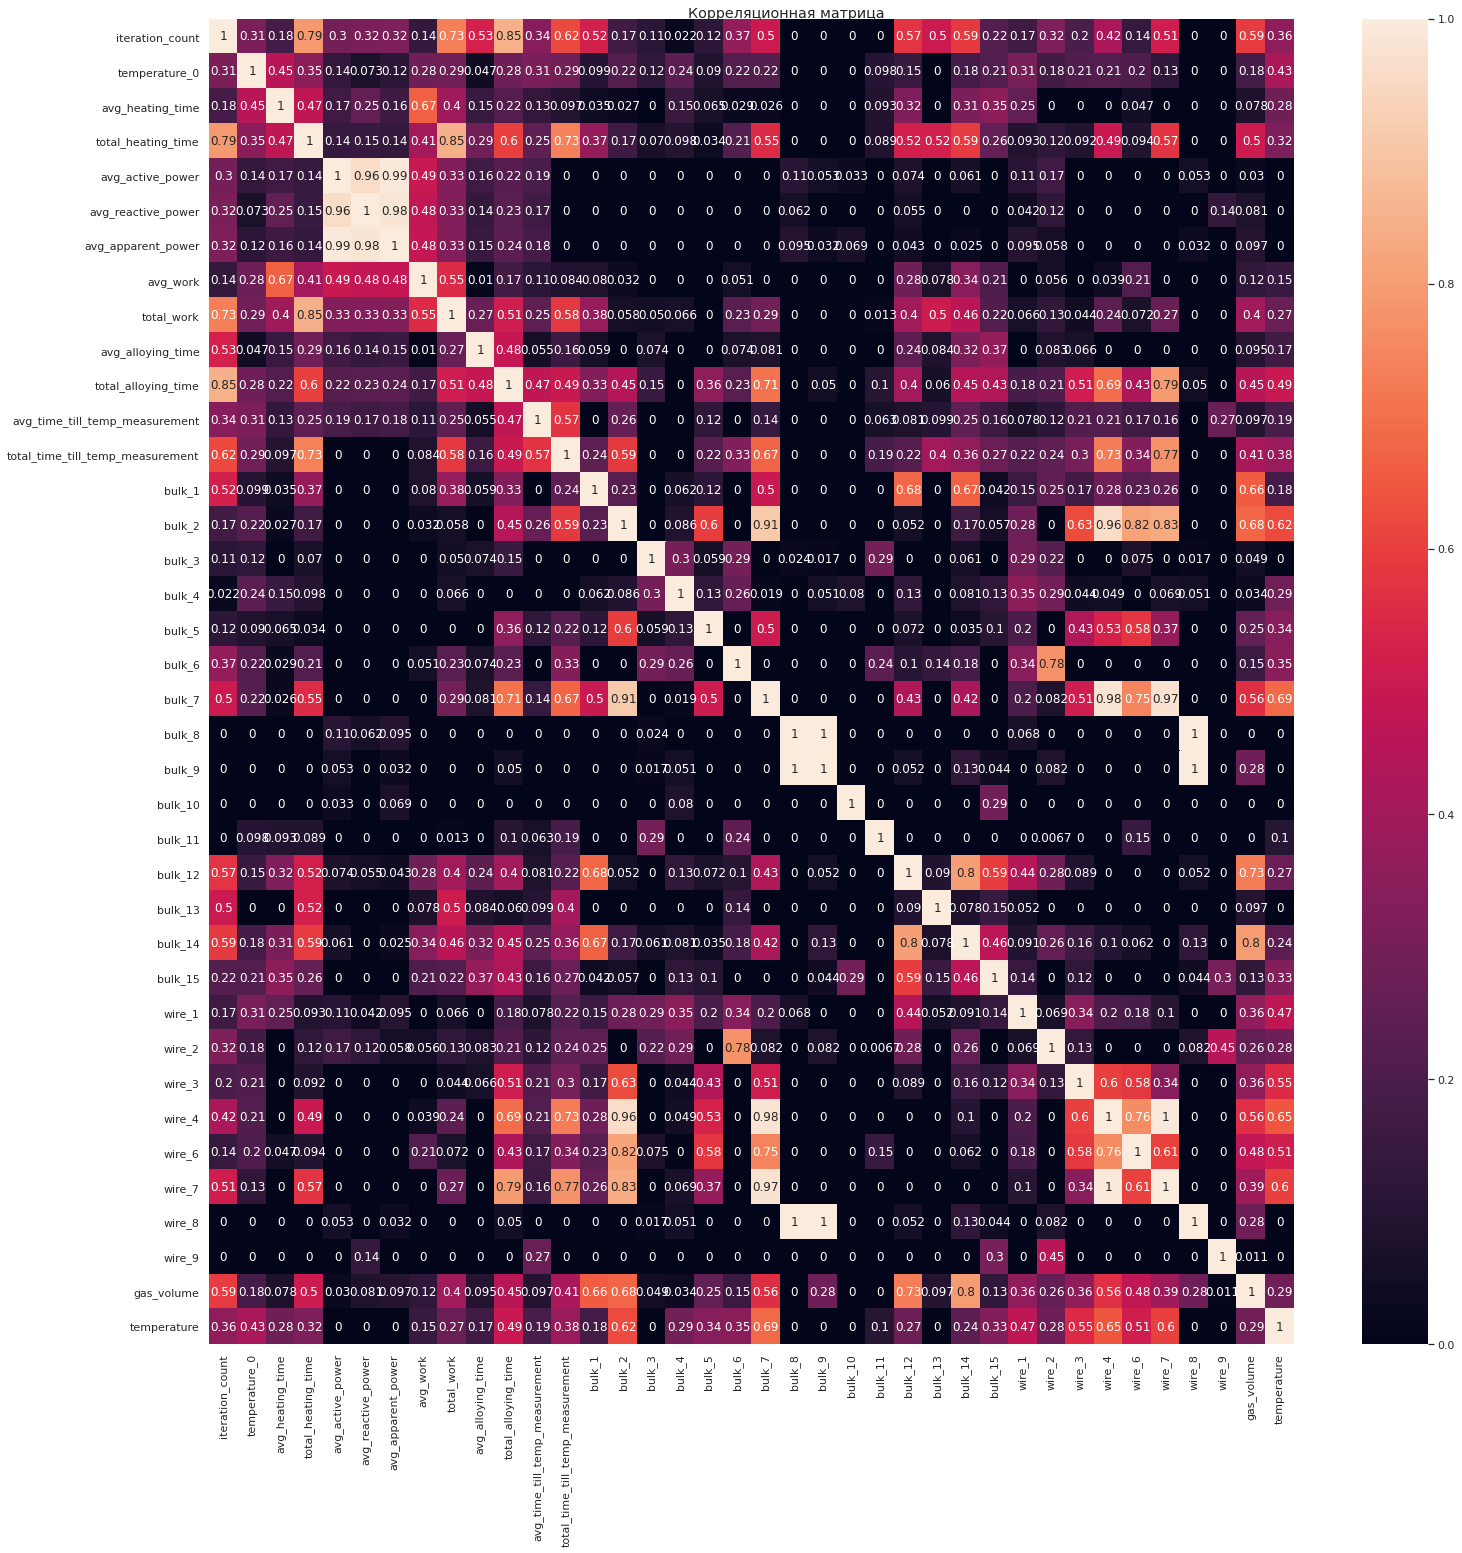

In [28]:
phik_matrix_heatmap(df, figsize=(22, 22))

Анализ корреляционной матрицы позволяет сделать несколько наблюдений:
- наибольшая корреляция с таргетом наблюдается у таких переменных, как `bulk_7`, `wire_4`, `bulk_2`, и `wire_7`;
- в данных присутствует мультиколлинеарность: коэф. корреляции в некоторых парах входных признаков больше 0.9. Такие признаки необходимо убрать, если будут использованы линейные модели (чтобы не было переоценки весов), либо использовать модели, для которых мультиколлинеарность не критична. Например, деревья и бустинг - такой вариант мы и будем использовать в данном проекте;
- признаки `avg_active_power`, `avg_reactive_power`, `avg_apparent_power`, `bulk_3`, `bulk_8`, `bulk_9`, `bulk_10`, `bulk_13`, `wire_8` и `wire_9` имеют нулевой коэф. корреляции с целевой переменной, однако данные признаки мы тоже оставим, чтобы посмотреть как они в конечном счете повлияют на модель.

**Вывод:** в данном разделе был проведен исследовательский анализ данных, включающий в себя анализ количественных переменных и корреляционный анализ. В результате были сделаны следующие наблюдения:
- в данных имеется значительное количество выбросов по многим признакам, однако было принято решение их оставить, чтобы не ограничивать предсказательную способность модели в узком диапазоне значений признаков;
- для некоторых легирующих добавок в датасете представлено очень мало данных, что может негативно сказаться на качестве модели;
- согласно результатам корреляционного анализа, наибольшая корреляция с таргетом наблюдается у таких переменных `bulk_7`, `wire_4`, `bulk_2` и `wire_7`;
- в данных присутствует мультиколлинеарность: коэф. корреляции в некоторых парах входных признаков больше 0.9, что определило пул возможных моделей, которые необходимо использовать - деревья и бустинги;
- признаки `avg_active_power`, `avg_reactive_power`, `avg_apparent_power`, `bulk_3`, `bulk_8`, `bulk_9`, `bulk_10`, `bulk_13`, `wire_8` и `wire_9` имеют нулевой коэф. корреляции с целевой переменной. Тем не менее, данные признаки было решено оставить. 

## Подготовка данных

In [29]:
# делим датасет на выборки
X_train, X_test, y_train, y_test = train_test_split(
   df.drop('temperature', axis=1),
   df['temperature'],
   test_size = TEST_SIZE,
   random_state = RANDOM_STATE)

In [30]:
# проверим размерности
print(f"""Размерность тренировочной выборки:
      X_train - {X_train.shape}
      y_train - {y_train.shape}\n""")
print(f"""Размерность тестовой выборки:
      X_test - {X_test.shape}
      y_test - {y_test.shape}""")

Размерность тренировочной выборки:
      X_train - (1743, 38)
      y_train - (1743,)

Размерность тестовой выборки:
      X_test - (581, 38)
      y_test - (581,)


In [31]:
# задаем списки с категориальными и числовыми признаками
ord_columns = ['iteration_count']
num_columns = X_train.columns.tolist()
num_columns.remove('iteration_count')

In [32]:
# создаем пайплайн для OrdinalEncoder (после кодирования заполняем пропуски с п-ю SimpleImputer)
ord_pipe = make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan),
    SimpleImputer(strategy='most_frequent')
)

# создаём общий пайплайн для подготовки данных
col_transform = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

Пайплайн для подготовки данных завершен. В рамках настройки `OrdinalEncoder` были добавлены параметры `handle_unknown='use_encoded_value', unknown_value=np.nan`. Это означает, что если обученный кодировщик встретит незнакомое значение в новых тестовых данных, предоставленных бизнесом, то такие значения будут заменяться на пропуски. Затем эти пропуски будут заполнены самым частым значением при помощи `SimpleImputer()`.

**Вывод:** в данном разделе данные были разделены на тренировочную и тестовую выборки, а также подготовлен пайплайн подготовки данных, включающий масштабирование количественных переменных с п-ю `StandardScaler` и кодирование дискретных признаков с п-ю `OrdinalEncoder`.

## Обучение модели

Согласно брифу:
> Обучите как минимум две модели. Хотя бы для одной из них подберите как минимум два гиперпараметра.

Как уже упоминалось ранее, мы будем использовать деревья и бустинги, а именно: `RandomForestRegressor`, `CatBoostRegressor`, `LGBMRegressor`. Теперь создадим список моделей и диапазоны их гиперпараметров, в пределах которых мы будем искать лучшую модель. Подбор гиперпараметров будем делать с помощью `RandomizedSearchCV` с кросс-валидацией. Модели и диапазоны гиперпараметров:

1. `RandomForestRegressor` - ансамбль решающих деревьев:
    - `max_depth`: от 2 до 10;
    - `min_samples_split`: от 2 до 10.
2. `CatBoostRegressor` - градиентный бустинг CatBoost:
    - `learning_rate`: от 0.001 до 0.1;
    - `depth`: от 2 до 10.
3. `LGBMRegressor` - градиентный бустинг LightGBM:
    - `learning_rate`: от 0.001 до 0.1;
    - `depth`: от 2 до 10.

In [ ]:
# задаем список моделей
models = [
    RandomForestRegressor(random_state=RANDOM_STATE),
    CatBoostRegressor(verbose=0, random_state=RANDOM_STATE),
    LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)
]

# задаем список словарей с диапазонами гиперпараметров моделей
params = [
    # параметры RandomForestRegressor
    {
        'randomforestregressor__max_depth': range(2, 11),
        'randomforestregressor__min_samples_split': range(2, 11)
    },

    # параметры CatBoostRegressor
    {
        'catboostregressor__learning_rate': np.linspace(0.001, 0.2, 10),
        'catboostregressor__depth': range(2, 11)
    },

    # параметры LGBMRegressor
    {
        'lgbmregressor__learning_rate': np.linspace(0.001, 0.2, 10),
        'lgbmregressor__max_depth': range(2, 11)
    }
]

Теперь перейдем непосредственно к обучению моделей и оценке качества. Последовательность действий такая:
- в цикле проходимся по моделям, для каждой подбираем гиперпараметры и обучаем;
- результаты поиска для каждой модели сохраняем в словарь `search_dict`;
- добавляем результаты по модели в таблицу `models_CV_results`.

In [ ]:
# создаем пустую таблицу для вывода результатов сравнения метрик моделей
models_CV_results = pd.DataFrame(columns=['model', 'parameters', 'MAE CV'])

# создаем пустой словарь для сохранения результатов поиска
search_dict = {}

# проходим в цикле по моделям
for i, model in enumerate(tqdm(models)):
    # создаем общий пайплайн
    pipe = make_pipeline(col_transform, model)
    # подбираем гиперпараметры модели
    rs = RandomizedSearchCV(
        pipe,
        params[i],
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        error_score='raise',
        random_state=RANDOM_STATE
    ).fit(X_train, y_train)

    # сохраняем результаты поиска в словарь
    search_dict[rs.best_estimator_[-1].__class__.__name__] = rs

# заполняем таблицу с результатами для каждой найденной модели
for key, rs in search_dict.items():
    models_CV_results.loc[len(models_CV_results)] = [
        key,
        rs.best_params_,
        rs.best_score_ * -1
    ]

# выводим таблицу с результатами
models_CV_results.sort_values(by='MAE CV')

100%|██████████| 3/3 [18:39<00:00, 373.02s/it]


,model,parameters,MAE CV
2,LGBMRegressor,"{'lgbmregressor__max_depth': 2, 'lgbmregressor...",6.079478
1,CatBoostRegressor,{'catboostregressor__learning_rate': 0.0452222...,6.180533
0,RandomForestRegressor,{'randomforestregressor__min_samples_split': 2...,6.328582


Гиперпараметры моделей подобраны. Как можно заметить, лучшую метрику MAE на кросс-валидации показал градиентный бустинг `LightGBM Regressor` - 6.08. Бустинг `CatBoost` и дерево `RandomForestRegressor` показали результаты чуть хуже - 6.18 и 6.33, соответственно.

In [35]:
# выведем параметры лучшей модели
search_dict['LGBMRegressor'].best_params_

{'lgbmregressor__max_depth': 2,
 'lgbmregressor__learning_rate': 0.1557777777777778}

**Вывод:** в данном разделе было проведено обучение моделей с подбором гиперпараметров: `RandomForestRegressor`, `CatBoostRegressor` и `LGBMRegressor`. Результаты показали, что `LGBMRegressor` с определенным набором гиперпараметров (`'lgbmregressor__max_depth': 2,
 'lgbmregressor__learning_rate': 0.1557777777777778`) обеспечил самую низкую среднюю абсолютную ошибку (MAE) на кросс-валидации - 6.08. Значения MAE для остальных моделей оказалось немного выше, что означает их более низкую точность прогнозирования.

## Тестирование и проверка модели на адекватность

In [36]:
# делаем прогноз на тестовой выборке
model = search_dict['LGBMRegressor']
y_pred = model.predict(X_test)

# выводим значение метрик MAE и R2
print(f"MAE на тестовой выборке: {mean_absolute_error(y_test, y_pred)}")
print(f"R2 на тестовой выборке: {r2_score(y_test, y_pred)}")

MAE на тестовой выборке: 5.781087561015122
R2 на тестовой выборке: 0.4917165343495471


Результаты на тестовой выборке следующие: `MAE = 5.78`, `R2 = 0.49`. Такой низкий показатель коэффициента детерминации подтверждает факт недообучения модели, вследствие малого количества данных по большинству легирующих компонентов - модель на таком наборе данных неулавливает оптимальное количество зависимостей в данных и от этого растет $bias^2$ - это потенциальная точка роста, надо дособирать данные и качество модели вырастет. 

Последний шаг в оценке качества получившийся модели - проверка модели на адекватность. Сравним качество нашей модели с Dummy-моделью `DummyRegressor`.

In [37]:
# обучаем dummy-модель
dummy_regr = DummyRegressor(strategy="mean").fit(X_train, y_train)

# делаем предсказание
dummy_pred = dummy_regr.predict(X_test)

# вычисляем метрику RMSE dummy-модели
print(f"MAE dummy-модели: {mean_absolute_error(y_test, dummy_pred)}")

MAE dummy-модели: 7.865381368108288


Как можно заметить, наша модель показала результат сильно лучше на тесте, чем у dummy-модели (5.78 на нашей модели, против 7.87 у dummy), что позволяет сделать вывод о ее адекватности.

**Вывод:** в данном разделе было оценено качество обученной модели `LGBMRegressor` с подобранными гиперпараметрами. Как показали результаты тестирования, метрика MAE данной модели на тесте составила 5.78, R2 - 0.49. Также данная модель прошла проверку на адекватность путем сравнения с константной моделью `DummyRegressor` (5.78 на нашей модели, против 7.87 у dummy).

## Анализ важности признаков

Заключительным этапом данного проекта будет анализ важности признаков для найденной лучшей модели. Проводить этот анализ будем с п-ю метода `SHAP`. Для начала посмотрим общую важность признаков для модели.

In [38]:
# сохраняем названия столбцов после предобработки, тренировочную и тестовую выборки
feature_names = model.best_estimator_['columntransformer'].get_feature_names_out()
preprocessed_X_train = pd.DataFrame(model.best_estimator_['columntransformer'].fit_transform(X_train), columns=feature_names)
preprocessed_X_test = pd.DataFrame(model.best_estimator_['columntransformer'].transform(X_test), columns=feature_names)

# обучаем модель
estimator = model.best_estimator_[-1].fit(preprocessed_X_train, y_train)

# рассчитываем SHAP-значения с п-ю метода перестановки, который реализован в PermutationExplainer
explainer = shap.PermutationExplainer(estimator.predict, preprocessed_X_test, seed=RANDOM_STATE, feature_names=feature_names)
shap_values = explainer(preprocessed_X_test)

PermutationExplainer explainer: 582it [02:14,  4.12it/s]                         


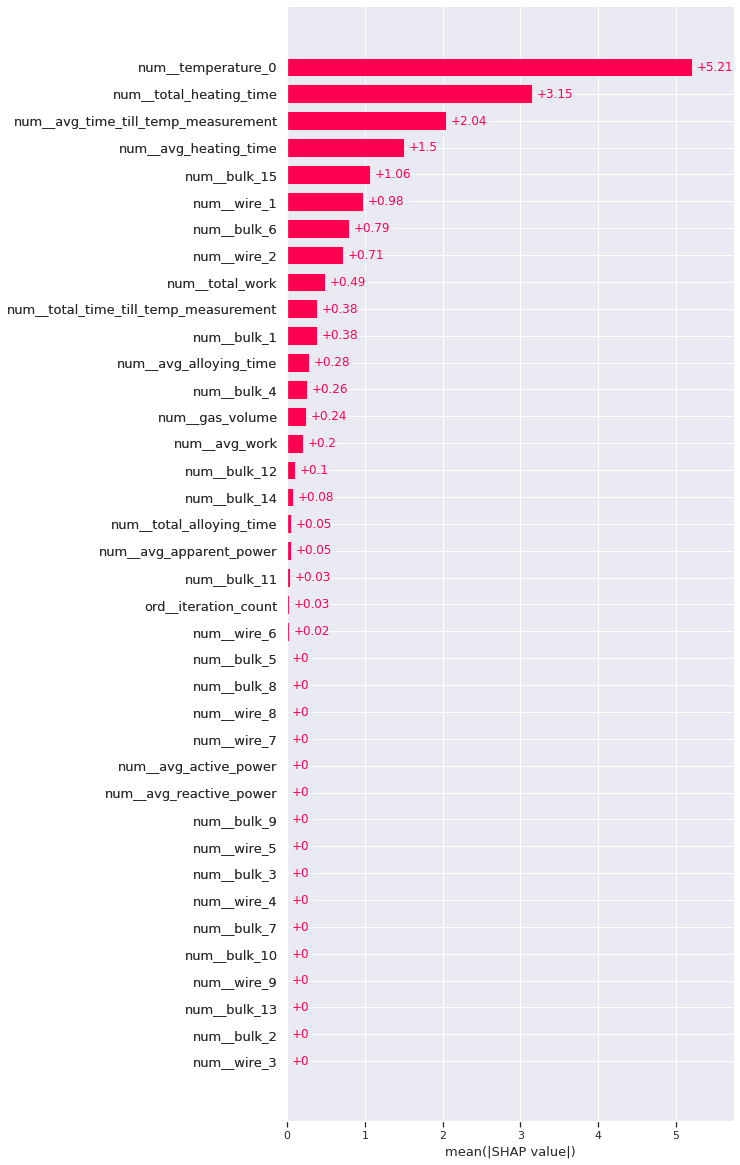

In [39]:
# строим диаграмму bar
try:
    shap.plots.bar(shap_values, max_display=X_train.columns.shape[0])
except Exception as exp:
    print(f"Error: {exp}")

Как можно заметить, результат вполне закономерный и логичный - больше всего на температуру расплава после обработки влияет начальная температура, продолжительность стадий нагрева и продувки-перемешивания. Далее по важности идут несколько легирующих компонентов: `bulk_15`, `wire_1`, `bulk_6` и `wire_2` - можно сделать осторожное предположение, что эти признаки важны для предсказательной способности модели, так как их добавление вносит заметный вклад в теплоемкость расплава и, следовательно, заметно влияет на его конечную температуру.

Также важно отметить, что у целого ряда легирующих компонентов важность находится на нулевом уровне, но при этом нельзя наверняка утверждать, что их добавление не влияет на температуру расплава, потому что в нашем датасете очень мало данных по этим компонентам. Отсюда можно сформулировать следующую рекомендацию: для дальнейшего улучшения предсказательной способности модели можно запросить дополнительные данные по сплавам, в которых добавляются данные компоненты.

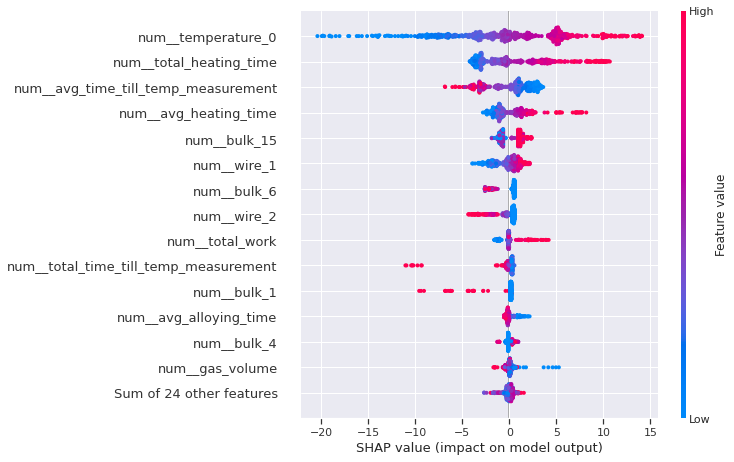

In [40]:
# строим диаграмму beeswarm
shap.plots.beeswarm(shap_values, max_display=15)

По данному графику можно сделать еще одно интересное наблюдение: добавление легирующих компонентов `bulk_15` и `wire_1` повышает конечную температуру расплава, а `bulk_6`, `wire_2` и `bulk_1` - понижает. Это можно объяснить различием в теплоемкости компонентов - в первом случае добавки наверняка имеют удельную теплоемкость ниже, чем у расплава, поэтому их добавка снижает теплоемкость всей системы и, соответственно, расплав легче нагреть - можно потратить меньше электроэнергии. А во втором случае добавки скорее всего более тугоплавкие и их добавление в расплав только увеличивает его теплоемкость и, соответственно, энергии на его нагрев нужно потратить больше.

Соответственно, приготовление рецептур с данными легирующими компонентами, при прочих равных, более энергоэффективно. 

**Вывод:** в данном разделе был проведен анализ важности признаков для выбранной модели с использованием метода `SHAP`. Результаты анализа показали ожидаемую взаимосвязь между начальной температурой, продолжительностью стадий нагрева и продувки-перемешивания с конечной температурой расплава.

Среди легирующих компонентов особую роль играют `bulk_15`, `wire_1`, `bulk_6` и `wire_2`, что можно объяснить их влиянием на теплоемкость расплава. Однако, у ряда компонентов важность оказалась на нулевом уровне, что может свидетельствовать о необходимости дополнительного сбора данных для улучшения предсказательной способности модели.

Также было замечено, что добавление некоторых легирующих компонентов по-разному влияет на конечную температуру расплава. Например, `bulk_15` и `wire_1` способствуют её повышению, в то время как `bulk_6`, `wire_2` и `bulk_1` - понижению. Это можно интерпретировать с точки зрения удельной теплоемкости компонентов, что имеет практическое значение для повышения энергоэффективности процесса.

## Общий вывод

Целью данного проекта была разработка модели машинного обучения для предсказания температуры сплава на этапе обработки стали с целью уменьшения потребления электроэнергии. Проект был разделен на этапы, на каждом из которых решались конкретные задачи:

1. **Загрузка данных:** Были загружены и первично осмотрены данные из 7 таблиц, предоставленных для анализа.
2. **Предобработка данных:** Проведена очистка данных, включающая исправление аномалий, обработку пропусков, приведение типов данных к верным форматам и проверку на дубликаты.
3. **Объединение данных:** Разработана стратегия объединения данных на основе выявленных параметров техпроцесса, которые могли бы влиять на конечную температуру расплава стали.
4. **EDA** (Исследовательский анализ данных): Проведен подробный анализ количественных переменных и корреляционный анализ для оценки структуры и взаимосвязей в данных.
5. **Подготовка данных:** Данные были разделены на тренировочную и тестовую выборки, а также был подготовлен пайплайн масштабирования и кодирования переменных.
6. **Обучение моделей:** Были обучены и оптимизированы три модели: `RandomForestRegressor`, `CatBoostRegressor` и `LGBMRegressor`. Лучшей моделью оказалась модель градиентного бустинга `LGBMRegressor(learning_rate=0.1557777777777778, max_depth=2, random_state=170624, verbose=-1)`, которая показала метрику `MAE` на кросс-валидации 6.08.
7. **Тестирование и проверка модели на адекватность:** На данном этапе была проведена оценка качества найденной лучшей модели на тестовой выборке. Результат тестирования показал, что метрика `MAE` на тестовой выборке составила 5.78, а метрика `R2` - 0.49. Также данная модель успешно прошла проверку на адекватность путем сравнения ее с константной моделью `DummyRegressor` (`MAE` = 5.78 против 7.87 у dummy).  
8. **Анализ важности признаков:** Проведен анализ важности признаков с использованием метода SHAP для интерпретации влияния каждого признака на целевую переменную.

Среди рекомендаций бизнесу, которые могут повысить энергоэффективность процесса обработки стали, можно выделить следующее:
- добавление некоторых легирующих компонентов (`bulk_15`, `wire_1`, `bulk_6`, `wire_2` и `bulk_1`) по разному влияет на конечную температуру расплава, вследствие повышения или понижения удельной теплоемкости расплава. Рецептуры на основе данных компонентов, потенциально, обеспечивают более энергоэффективный процесс легирования;
- недостаток данных по некоторым редким легирующим компонентам может снижать предсказательную способность модели. Рекомендуется расширить сбор данных для улучшения качества будущих прогнозов;
- разработанную модель можно использовать для прогнозирования температуры расплава с достаточно высокой точностью, что позволит оптимизировать процесс нагрева и снизить энергозатраты. Однако, следует предусмотреть регулярное пополнение новыми данными, чтобы сохранить её точность и стабильность прогнозов в условиях изменяющихся технологических процессов и нестабильных свойств сырьевых материалов.